In [2]:
# !pip install langgraph langchain langchain-openai langgraph-checkpoint-sqlite langchain-community langchain_experimental pandas 
# !apt-get install -y graphviz graphviz-dev
# !pip install pygraphviz

In [10]:
import os
import sqlite3
import pandas as pd
import re
import json
from typing import TypedDict, List, Dict, Any, Optional, Literal

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END

In [11]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["OPENAI_API_KEY"] = user_secrets.get_secret("OPENAI_API_KEY")

In [12]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [13]:
def jprint(obj, prefix=""):
    print(prefix + json.dumps(obj, indent=2, ensure_ascii=False))

### load data -> SQLite

In [14]:
conn = sqlite3.connect(":memory:")

patients = pd.read_csv("/kaggle/input/synthea-dataset/patients.csv")
conditions = pd.read_csv("/kaggle/input/synthea-dataset/conditions.csv")
medications = pd.read_csv("/kaggle/input/synthea-dataset/medications.csv")
observations = pd.read_csv("/kaggle/input/synthea-dataset/observations.csv")

_ = patients.to_sql("patients", conn, index=False, if_exists="replace")
_ = conditions.to_sql("conditions", conn, index=False, if_exists="replace")
_ = medications.to_sql("medications", conn, index=False, if_exists="replace")
_ = observations.to_sql("observations", conn, index=False, if_exists="replace")

# row count
for t in ["patients","conditions","medications","observations"]:
    cnt = pd.read_sql(f"SELECT COUNT(*) AS n FROM {t}", conn)["n"].iloc[0]
    print(f"{t}: {cnt:,} rows")


patients: 1,462 rows
conditions: 7,040 rows
medications: 6,048 rows
observations: 79,674 rows


### helper

In [15]:
ALLOWED_TABLES = {"patients","conditions","medications","observations"}

def get_schema_text() -> str:
    cur = conn.cursor()
    cur.execute("SELECT name, sql FROM sqlite_master WHERE type='table'")
    rows = cur.fetchall()
    return "\n".join(f"{name}: {sql}" for name, sql in rows if name in ALLOWED_TABLES)

def table_columns(table: str) -> List[str]:
    cur = conn.cursor()
    cur.execute(f"PRAGMA table_info({table})")
    return [r[1] for r in cur.fetchall()]

def default_patient_columns(max_n: int = 4) -> List[str]:
    cols = table_columns("patients")
    preferred = [c for c in cols if c.upper() in {"ID","FIRST","LAST","GENDER","GIVENNAME","SURNAME"}]
    return (preferred or cols)[:max_n]

def probe_values(tables: List[str], limit_per_col: int = 6) -> Dict[str, Dict[str, List[Any]]]:
    """
    For likely categorical columns or mentioned columns, collect a few distinct values.
    """
    likely_cat = {"GENDER","RACE","ETHNICITY","MARITAL","DESCRIPTION","CODE","VALUE","ENCOUNTERCLASS"}
    samples: Dict[str, Dict[str, List[Any]]] = {}
    cur = conn.cursor()

    for t in tables:
        if t not in ALLOWED_TABLES:
            continue
        cols = table_columns(t)
        samples[t] = {}
        for c in cols:
            if c.upper() in likely_cat or re.search(r"(GENDER|RACE|ETHNIC|DESC|CODE|TYPE|CLASS|STATUS)", c, re.I):
                try:
                    cur.execute(f'SELECT DISTINCT "{c}" FROM {t} WHERE "{c}" IS NOT NULL LIMIT {limit_per_col}')
                    vals = [r[0] for r in cur.fetchall()]
                    if vals:
                        samples[t][c] = vals
                except Exception:
                    pass
    return samples

def ensure_select_only(sql: str):
    if not re.match(r"^\s*SELECT\b", sql, re.I):
        raise ValueError("Only SELECT statements are allowed.")
    parts = [p for p in sql.split(";") if p.strip()]
    if len(parts) > 1:
        raise ValueError("Multiple SQL statements are not allowed.")

def auto_limit_if_needed(sql: str) -> str:
    # If non-aggregate SELECT and no LIMIT, add LIMIT 100
    if not re.search(r"\b(COUNT|AVG|SUM|MIN|MAX)\s*\(", sql, re.I):
        if not re.search(r"\bLIMIT\s+\d+\b", sql, re.I):
            return sql.rstrip().rstrip(";") + " LIMIT 100;"
    return sql

def is_count_sql(sql: str) -> bool:
    return bool(re.match(r"^\s*SELECT\s+COUNT\s*\(", sql, re.I))


In [16]:
class IntentFilter(BaseModel):
    column: Optional[str] = None
    op: Optional[str] = None
    value: Optional[str] = None  

class IntentResponse(BaseModel):
    intent_type: Literal["count","select","aggregate","other"] = "select"
    targets: List[str] = Field(default_factory=list)
    filters: List[IntentFilter] = Field(default_factory=list)
    group_by: List[str] = Field(default_factory=list)
    complexity: Literal["low","medium","high"] = "low"

class SchemaMapResponse(BaseModel):
    tables: Optional[List[str]] = Field(default_factory=list)
    join_keys: Optional[List[List[str]]] = Field(default_factory=list)
    columns: Optional[Dict[str, List[str]]] = Field(default_factory=dict)
    
class EvalResponse(BaseModel):
    credible: bool
    reason: str
    suggested_fix: Optional[str] = None

class DiagResponse(BaseModel):
    error_type: Literal["schema","syntax","logic","unknown"] = "unknown"
    fix_suggestion: str = ""
    needs_human: bool = False


### prompts

In [17]:
analyzer_prompt = ChatPromptTemplate.from_messages([
    ("system", "You extract structured intent from a healthcare data question."),
    ("human",
     "Question: {query}\n"
     "Return JSON with fields:\n"
     "{{intent_type: one of [count, select, aggregate], "
     "targets: [tables or entities], "
     "filters: [{{column, op, value (conceptual)}}], "
     "group_by: [...], complexity: low/medium/high}}")
])

schema_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a schema mapper. Use the DDL (CREATE TABLE ...) and the question intent to pick tables, columns and key joins."),
    ("human",
     "DDL:\n{ddl}\n\n"
     "Question: {query}\n"
     "Intent JSON: {intent_json}\n"
     "Return JSON in the form:\n"
     "{{tables: [...], join_keys: [[left.col,right.col],...], columns: {{table:[cols]}}}}")
])


sql_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Write a single valid SQLite SELECT statement.\n"
     "Rules:\n"
     "- Use only the provided tables, columns, and join_keys from the schema hints.\n"
     "- Do not invent columns. Only use exact column names.\n"
     "- For measurements like weight, height, blood pressure, etc., use the 'observations' table:\n"
     "    • DESCRIPTION → type of measurement (e.g., 'Body Weight', 'Body Height')\n"
     "    • VALUE → numeric result (cast to FLOAT if needed)\n"
     "    • UNITS → measurement units\n"
     "- For patient demographics, use 'patients'.\n"
     "- For diagnoses, use 'conditions' (DESCRIPTION for condition name).\n"
     "- For prescriptions, use 'medications' (DESCRIPTION for drug name).\n"
     "- COUNT queries must NOT use LIMIT.\n"
     "- Prefer exact tokens found in provided value_samples (e.g., use 'F' if sample shows ['F','M']).\n"
     "- Always use table aliases: patients → p, conditions → c, medications → m, observations → o.\n"
     "- If filtering on a type of observation, always match against o.DESCRIPTION (not ENCOUNTER, not ENTITY)."),
    ("human",
     "Question: {query}\n"
     "Intent: {intent_json}\n"
     "Schema hints: {schema_json}\n"
     "Value samples: {value_samples_json}\n"
     "Human hint (optional): {hint}\n"
     "Return only the SQL string (no extra text).")
])


eval_prompt = ChatPromptTemplate.from_messages([
    ("system", "Assess if the SQL result looks credible for the given question."),
    ("human",
     "Question: {query}\n"
     "Result preview (first rows): {result_preview}\n"
     "Value samples used: {value_samples_json}\n"
     "Return JSON: "
     "{{credible: true/false, reason: str, suggested_fix?: str}}")
])

diag_prompt = ChatPromptTemplate.from_messages([
    ("system", "Diagnose why SQL failed or result seems not credible; propose a fix or decide if human help is required."),
    ("human",
     "Question: {query}\n"
     "SQL: {sql}\n"
     "Problem: {problem}\n"
     "Value samples: {value_samples_json}\n"
     "Return JSON: "
     "{{error_type: schema|syntax|logic|unknown, fix_suggestion: str, needs_human: bool}}")
])


In [18]:
class AgentState(TypedDict):
    query: str
    analyzed_intent: Dict[str, Any]
    relevant_schema: Dict[str, Any]
    value_samples: Dict[str, Dict[str, List[Any]]]
    sql: str
    result: Dict[str, Any]
    errors: List[Dict[str, Any]]
    retry_count: int
    human_feedback: str
    feedback_is_sql: bool
    final: Dict[str, Any]
    hint: str  

### nodes

In [19]:
def analyze_node(state: AgentState) -> AgentState:
    chain = analyzer_prompt | llm.with_structured_output(IntentResponse)
    resp = chain.invoke({"query": state["query"]})
    state["analyzed_intent"] = resp.model_dump()
    print("▶ Analyzer")
    jprint(state["analyzed_intent"])
    return state

def schema_probe_node(state: AgentState) -> AgentState:
    chain = schema_prompt | llm.with_structured_output(SchemaMapResponse)
    resp = chain.invoke({
        "ddl": get_schema_text(),
        "query": state["query"],
        "intent_json": json.dumps(state["analyzed_intent"])
    })
    schema_map = resp.model_dump()

    # Filter allowed tables
    tables = schema_map.get("tables") or []
    valid_tables = [t for t in tables if t in ALLOWED_TABLES]

    if not valid_tables:
        # No valid tables -> escalate as schema error
        state["result"] = {"status": "err", "error": f"No valid tables found in query (requested {tables})"}
        state["errors"].append({"stage": "schema_probe", "msg": f"Invalid tables: {tables}"})
        return state

    schema_map["tables"] = valid_tables
    samples = probe_values(valid_tables)
    state["relevant_schema"] = schema_map
    state["value_samples"] = samples

    print("▶ Schema Mapper")
    jprint(schema_map)
    print("▶ Value Samples (compact)")
    jprint(samples)
    return state

def _fallback_sql(intent_type: str) -> str:
    if intent_type == "count":
        return "SELECT COUNT(*) FROM patients;"
    cols = ", ".join(default_patient_columns())
    return f"SELECT {cols} FROM patients LIMIT 10;"

def sql_gen_node(state: AgentState) -> AgentState:
    intent_type = state["analyzed_intent"].get("intent_type", "select")
    try:
        chain = sql_prompt | llm  # text out
        resp = chain.invoke({
            "query": state["query"],
            "intent_json": json.dumps(state["analyzed_intent"]),
            "schema_json": json.dumps(state["relevant_schema"]),
            "value_samples_json": json.dumps(state["value_samples"]),
            "hint": state.get("hint","")
        })
        sql_text = (resp.content if hasattr(resp, "content") else str(resp)).strip()
        m = re.search(r"(?is)\bSELECT\b.+", sql_text)
        sql_text = m.group(0).strip() if m else sql_text
        sql_text = re.sub(r"^```sql|^```|```$", "", sql_text, flags=re.I|re.M).strip()
        if not sql_text:
            raise ValueError("Empty SQL from generator.")
        state["sql"] = sql_text
    except Exception as e:
        state["errors"].append({"stage": "sql_gen", "msg": str(e)})
        state["sql"] = _fallback_sql(intent_type)

    print("▶ SQL")
    print(state["sql"])
    return state

def exec_node(state: AgentState) -> AgentState:
    try:
        ensure_select_only(state["sql"])
        conn.execute(f"EXPLAIN {state['sql']}")
        run_sql = auto_limit_if_needed(state["sql"])
        df = pd.read_sql(run_sql, conn)
        preview = df.head(5).to_dict()
        state["result"] = {"status": "ok", "preview": preview}
        print("▶ Exec: ok")
        jprint(preview)
    except Exception as e:
        err = str(e)
        state["result"] = {"status": "err", "error": err}
        state["errors"].append({"stage": "exec", "msg": err})
        print("▶ Exec: error →", err)
    return state

def eval_node(state: AgentState) -> AgentState:
    if state["result"].get("status") != "ok":
        return state

    if is_count_sql(state["sql"]):
        try:
            vals = list(state["result"]["preview"].values())
            if len(vals) != 1:
                raise ValueError("COUNT should return one column.")
            col_dict = vals[0]
            if len(col_dict) != 1:
                raise ValueError("COUNT should return one row.")
        except Exception as e:
            reason = f"Rule check: {e}"
            state["result"] = {"status": "err", "error": reason}
            state["errors"].append({"stage": "eval_rules", "msg": reason})
            print("▶ Eval (rules): not credible →", reason)
            return state

    # LLM evaluator
    chain = eval_prompt | llm.with_structured_output(EvalResponse)
    resp = chain.invoke({
        "query": state["query"],
        "result_preview": json.dumps(state["result"]["preview"]),
        "value_samples_json": json.dumps(state["value_samples"])
    })
    verdict = resp.model_dump()
    print("▶ Eval (LLM)")
    jprint(verdict)

    if not verdict.get("credible", True):
        state["result"] = {"status":"err", "error": verdict.get("reason", "Not credible")}
        state["errors"].append({"stage":"eval_llm","msg":verdict})
    else:
        state["final"] = state["result"]
    return state

def diag_node(state: AgentState) -> AgentState:
    problem = state["result"].get("error","Unknown issue")
    chain = diag_prompt | llm.with_structured_output(DiagResponse)
    resp = chain.invoke({
        "query": state["query"],
        "sql": state["sql"] or "(none)",
        "problem": problem,
        "value_samples_json": json.dumps(state["value_samples"])
    })
    diag = resp.model_dump()
    state["errors"].append({"stage":"diagnose", **diag})
    print("▶ Diagnose")
    jprint(diag)

    # Apply simple auto-fixes
    intent_type = state["analyzed_intent"].get("intent_type","select")
    if diag["error_type"] in {"syntax","logic","schema"} and diag["fix_suggestion"]:
        # If fix looks like SQL, try it directly; else, feed back as hint
        fix = diag["fix_suggestion"].strip()
        if re.match(r"^\s*SELECT\b", fix, re.I):
            state["sql"] = fix
        else:
            state["hint"] = fix  # natural-language hint to regen SQL
    else:
        state["sql"] = _fallback_sql(intent_type)

    state["retry_count"] += 1
    return state

def human_node(state: AgentState) -> AgentState:
    print("▶ HITL: Provide corrected SQL (starts with SELECT) OR a hint in plain English.")
    print("Last error:", state["result"].get("error",""))
    print("Current SQL:", state.get("sql","(none)"))
    fb = input("Your input: ").strip()
    state["human_feedback"] = fb
    if re.match(r"^\s*SELECT\b", fb, re.I):
        # Validate SQL quickly
        try:
            ensure_select_only(fb)
            conn.execute(f"EXPLAIN {fb}")
            state["sql"] = fb
            state["feedback_is_sql"] = True
            print("HITL: accepted SQL.")
        except Exception as e:
            state["feedback_is_sql"] = False
            state["hint"] = f"Invalid SQL provided ({e}); {fb}"
            print("HITL: invalid SQL, treating as hint.")
    else:
        state["feedback_is_sql"] = False
        state["hint"] = fb
        state["query"] = state["query"] + f" | Hint: {fb}"
        print("HITL: hint recorded.")
    return state


### graph

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node("analyze", analyze_node)
workflow.add_node("schema_probe", schema_probe_node)
workflow.add_node("sql_gen", sql_gen_node)
workflow.add_node("exec", exec_node)
workflow.add_node("eval", eval_node)
workflow.add_node("diagnose", diag_node)
workflow.add_node("human", human_node)

workflow.set_entry_point("analyze")
workflow.add_edge("analyze", "schema_probe")
workflow.add_edge("schema_probe", "sql_gen")
workflow.add_edge("sql_gen", "exec")
workflow.add_edge("exec", "eval")

def after_eval(state: AgentState) -> str:
    if state.get("final"):
        return END
    # Not final → decide next hop
    return "diagnose" if state.get("retry_count",0) < 3 else "human"

def after_diag(state: AgentState) -> str:
    return "human" if state.get("retry_count",0) >= 3 else "sql_gen"

def after_human(state: AgentState) -> str:
    return "exec" if state.get("feedback_is_sql", False) else "sql_gen"

workflow.add_conditional_edges("eval", after_eval, {END: END, "diagnose": "diagnose", "human": "human"})
workflow.add_conditional_edges("diagnose", after_diag, {"human":"human","sql_gen":"sql_gen"})
workflow.add_conditional_edges("human", after_human, {"exec":"exec","sql_gen":"sql_gen"})

graph = workflow.compile()

print("Graph compiled ")


Graph compiled 


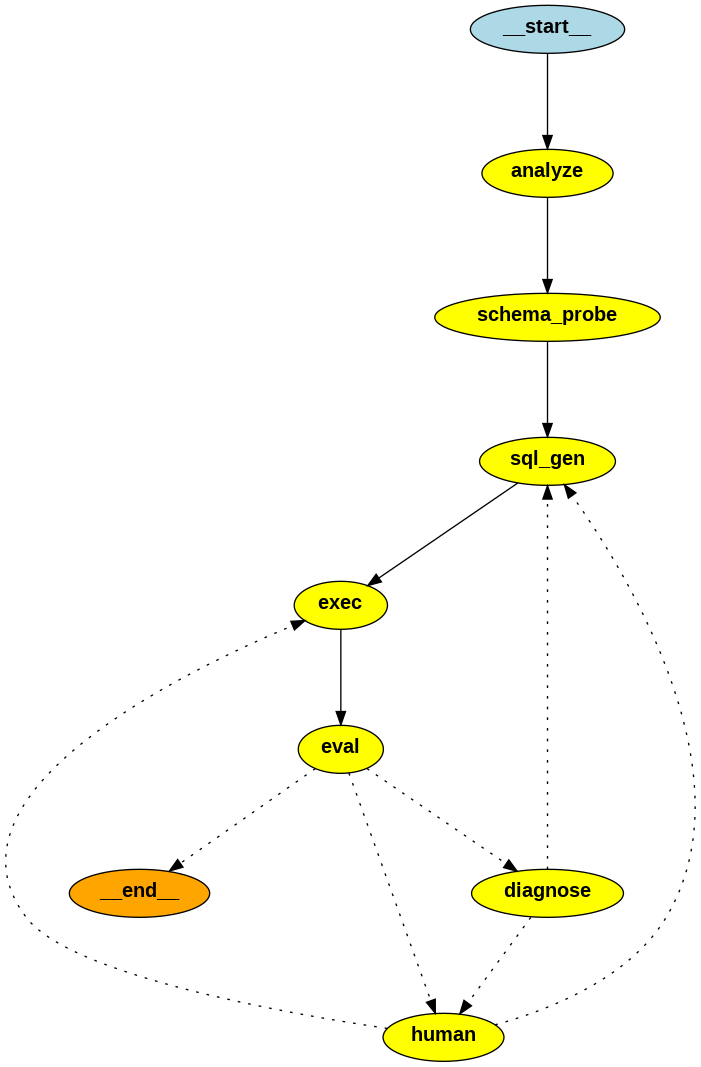

In [21]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [22]:
def initial_state(query: str) -> AgentState:
    return {
        "query": query,
        "analyzed_intent": {},
        "relevant_schema": {},
        "value_samples": {},
        "sql": "",
        "result": {},
        "errors": [],
        "retry_count": 0,
        "human_feedback": "",
        "feedback_is_sql": False,
        "final": {},
        "hint": ""
    }

In [23]:
def run_query(q: str) -> AgentState:
    print("\n" + "="*80)
    print("QUERY:", q)
    print("="*80)
    state = initial_state(q)
    out = graph.invoke(state)
    if out.get("final"):
        print("\n FINAL RESULT")
        jprint(out["final"])
    else:
        print("\n  FAILED (after retries)")
        print("Last error:", out.get("result",{}).get("error",""))
        print("SQL:", out.get("sql",""))
        print("Errors history:")
        jprint(out.get("errors",[]))
    return out

# demo

# _ = run_query("How many patients are female?")
# _ = run_query("Count patients who ever had cystitis.")
_ = run_query("List 10 rows from medications for Lenalidomide mentions.")
# _ = run_query("Show the average weight of patients who had acute bronchitis.")
# _ = run_query("Select from fake_table")
# _ = run_query("Count the number of observations per patient")



QUERY: List 10 rows from medications for Lenalidomide mentions.
▶ Analyzer
{
  "intent_type": "select",
  "targets": [
    "medications"
  ],
  "filters": [],
  "group_by": [],
  "complexity": "low"
}
▶ Schema Mapper
{
  "tables": [
    "medications"
  ],
  "join_keys": null,
  "columns": {
    "medications": [
      "START",
      "STOP",
      "PATIENT",
      "ENCOUNTER",
      "CODE",
      "DESCRIPTION",
      "REASONCODE",
      "REASONDESCRIPTION"
    ]
  }
}
▶ Value Samples (compact)
{
  "medications": {
    "CODE": [
      834060,
      1367439,
      608680,
      748879,
      568530,
      1094108
    ],
    "DESCRIPTION": [
      "Penicillin V Potassium 250 MG",
      "NuvaRing 0.12/0.015 MG per 24HR 21 Day Vaginal Ring",
      "Acetaminophen 160 MG",
      "Levora 0.15/30 28 Day Pack",
      "Nitrofurantoin 5 MG/ML [Furadantin]",
      "Phenazopyridine hydrochloride 100 MG [Pyridium]"
    ],
    "REASONCODE": [
      43878008.0,
      10509002.0,
      38822007.0,
      

Your input:  I accidentally asked for lenalidomide, I wanted to list medication related to acetaminophen


HITL: hint recorded.
▶ SQL
SELECT * FROM medications m WHERE m.DESCRIPTION LIKE '%Acetaminophen%' LIMIT 10;
▶ Exec: ok
{
  "START": {
    "0": "2009-01-11",
    "1": "1951-05-26",
    "2": "2010-06-22",
    "3": "2013-10-11",
    "4": "2014-07-23"
  },
  "STOP": {
    "0": "2009-01-21",
    "1": null,
    "2": "2010-09-22",
    "3": "2013-10-28",
    "4": "2014-09-19"
  },
  "PATIENT": {
    "0": "71949668-1c2e-43ae-ab0a-64654608defb",
    "1": "c2caaace-9119-4b2d-a2c3-4040f5a9cf32",
    "2": "96b24072-e1fe-49cd-a22a-6dfb92c3994c",
    "3": "79266ca2-b4e3-45e5-af65-7914bd4511a0",
    "4": "00630ce3-e8eb-4ed4-889b-2c0ac257cbf4"
  },
  "ENCOUNTER": {
    "0": "4d451e22-a354-40c9-8b33-b6126158666d",
    "1": "c35264e2-404f-4890-adc7-b5ce85e3901f",
    "2": "24293a59-d876-418c-9630-8e4f3731bd70",
    "3": "79b72d67-57c3-4312-a365-c0a995a0e616",
    "4": "1468e3c2-fb6c-43f6-a9f5-e78a8d43a4eb"
  },
  "CODE": {
    "0": 608680,
    "1": 1049221,
    "2": 313782,
    "3": 313782,
    "4": 2824